# 📊 Forecasting Migration Flows — Exploratory Data Analysis (EDA)

**Author:** _Golib Sanaev_  
**Date:** _2025-09-23_  
**Last Updated:** _2025-10-09_  
**Project:** Forecasting Migration Flows with Machine Learning  

---

### 🎯 **Purpose**

This notebook performs **exploratory data analysis (EDA)** on the cleaned datasets produced in [`01-data-preparation-and-cleaning.ipynb`](01-data-preparation-and-cleaning.ipynb). The goal is to uncover trends, relationships, and potential predictors of migration flows.

Key analytical steps include:
- Visualizing indicator distributions and time coverage.  
- Analyzing net migration trends across countries and aggregates.  
- Exploring correlations between migration and key economic/demographic indicators.  
- Detecting outliers, data clusters, and country-level case studies.

---

### 📑 **Table of Contents**

1. [Setup and Load Clean Data](#1-setup-and-load-clean-data)  
2. [Quick Sanity Checks](#2-quick-sanity-checks)  
3. [Indicator Distributions](#3-indicator-distributions)  
4. [Focus on Net Migration (per 1,000 People)](#4-focus-on-net-migration-per-1000-people)  
 4.1. [Distribution: Original vs. Capped](#41-distribution-original-vs-capped)  
 4.2. [Crisis Flag (for Modeling & EDA)](#42-crisis-flag-for-modeling--eda)  
 4.3. [Outlier Countries by Income Group](#43-outlier-countries-by-income-group)  
5. [Global Trend Over Time](#5-global-trend-over-time)  
6. [Country-Level Variation](#6-country-level-variation)  
7. [Top Migration Inflows and Outflows (Average 1990–2023)](#7-top-migration-inflows-and-outflows-average-19902023)  
8. [Global vs Regional Migration Trends](#8-global-vs-regional-migration-trends)  
9. [Correlation and Feature Relationships](#9-correlation-and-feature-relationships)  
10. [Country-Level Trends](#10-country-level-trends)  
11. [Key Insights Summary](#11-key-insights-summary)


## 1. Setup and Load Clean Data

> **Purpose:** Load the cleaned country- and aggregate-level datasets, set plotting style,
> and ensure key derived fields exist (e.g., per‑1,000 migration).

In [1]:
# --- Imports & setup ---
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Visualization style
sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.facecolor": "white", "axes.facecolor": "white"})

# Paths & data
DATA_DIR = Path("../data/processed")
df_country = pd.read_csv(DATA_DIR / "countries_clean.csv")
df_agg = pd.read_csv(DATA_DIR / "aggregates_clean.csv")

print(f"Countries dataset: {df_country.shape}")
print(f"Aggregates dataset: {df_agg.shape}")

# Ensure net_migration_per_1000 exists
if "net_migration_per_1000" not in df_country.columns:
    df_country["net_migration_per_1000"] = (df_country["net_migration"] / df_country["population"]) * 1000
    print("Created 'net_migration_per_1000' from net_migration and population.")


Countries dataset: (5712, 21)
Aggregates dataset: (1496, 18)
Created 'net_migration_per_1000' from net_migration and population.


## 2. Quick Sanity Checks

> **Purpose:** Verify coverage (countries × years) and check basic missingness before analysis.

In [2]:
# Coverage
n_countries = df_country["Country Name"].nunique()
n_years = df_country["year"].nunique()
print(f"Unique countries: {n_countries}, years: {n_years}, expected rows: {n_countries*n_years:,}")
print(f"Actual rows: {len(df_country):,}")

# Basic NA check
na_cols = df_country.isna().sum()
print("Columns with any missing values (should be 0 except metadata if any):")
display(na_cols[na_cols>0])

# Order IncomeGroup for nicer plots (drop unused)
if "IncomeGroup" in df_country.columns:
    order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
    df_country["IncomeGroup"] = pd.Categorical(df_country["IncomeGroup"], categories=order, ordered=True)
    df_country = df_country[df_country["IncomeGroup"].notna()].copy()


Unique countries: 168, years: 34, expected rows: 5,712
Actual rows: 5,712
Columns with any missing values (should be 0 except metadata if any):


Series([], dtype: int64)

---

## 3. Indicator Distributions

Understanding the overall data landscape helps contextualize migration patterns.
Before diving deeper into migration, we explore the **distributions of key socio-economic
and demographic indicators** — such as GDP, fertility, life expectancy, and population growth.

> **🧭 Interpretation tip:**  
> - Skewed or heavy-tailed variables (e.g., GDP per capita, population) may require log transformation during modeling.  
> - The shape of each distribution highlights global disparities and helps spot measurement or scale inconsistencies.  
> - Comparing **net migration** to other indicators reveals whether extreme migration rates are common or exceptional.

---


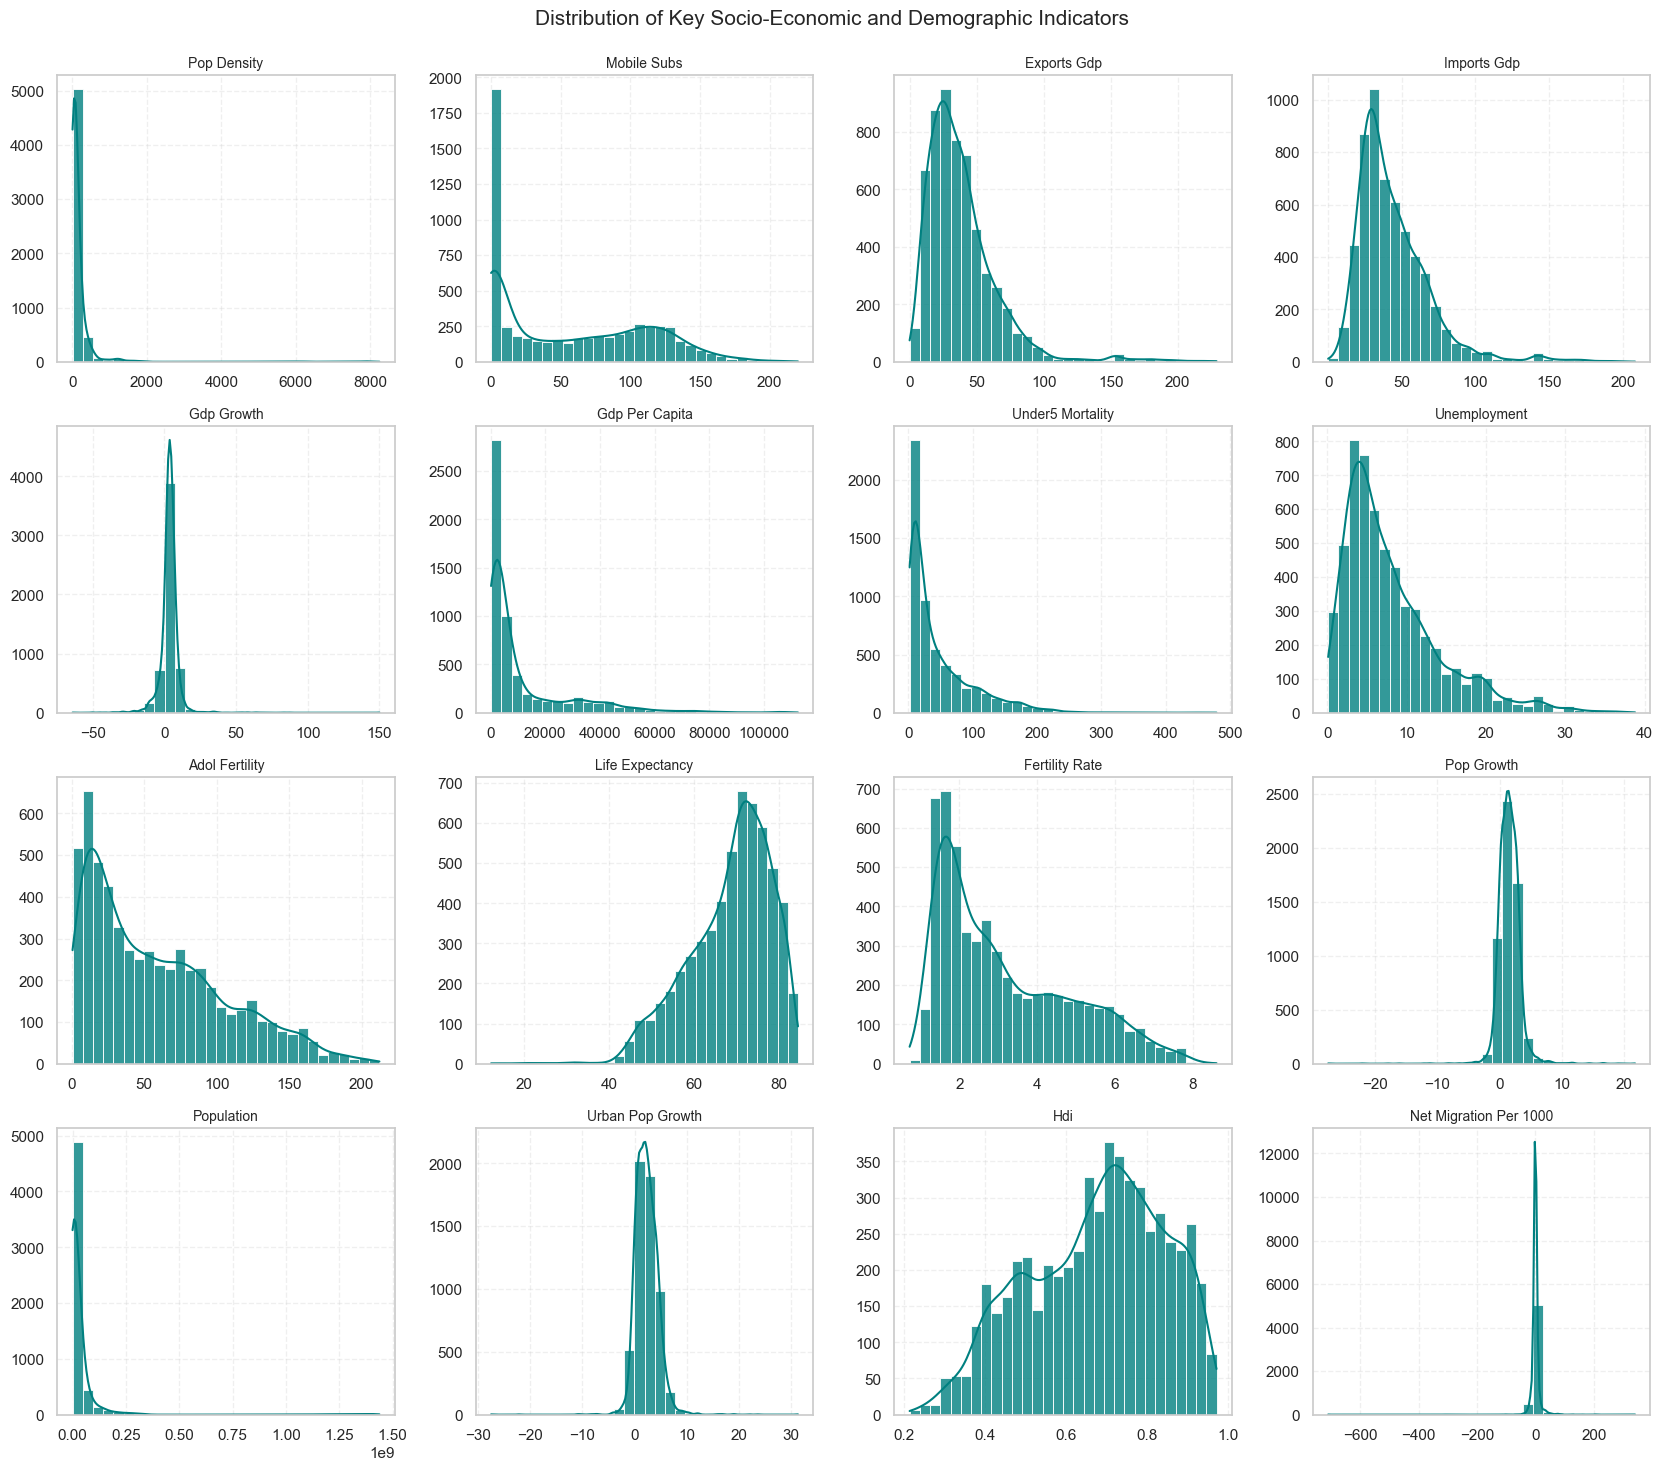

In [3]:
# List of key numeric columns
numeric_cols = [
    "pop_density", "mobile_subs", "exports_gdp", "imports_gdp",
    "gdp_growth", "gdp_per_capita", "under5_mortality", "unemployment",
    "adol_fertility", "life_expectancy", "fertility_rate", "pop_growth",
    "population", "urban_pop_growth", "hdi", "net_migration_per_1000"
]

# Filter to existing columns
numeric_cols = [c for c in numeric_cols if c in df_country.columns]

# Grid setup
n_cols = 4
n_rows = math.ceil(len(numeric_cols) / n_cols)

# Plot histograms
plt.figure(figsize=(n_cols * 4.2, n_rows * 3.6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df_country[col], kde=True, bins=30, color="teal", alpha=0.8)
    plt.title(col.replace("_", " ").title(), fontsize=10)
    plt.xlabel(""); plt.ylabel("")
    plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.suptitle("Distribution of Key Socio-Economic and Demographic Indicators", fontsize=15, y=1.02)
plt.show()


## 4. Focus on Net Migration (per 1,000 People)

> **Interpretation tip:** The distribution is concentrated around zero, with a small set of countries
exhibiting extreme inflows (e.g., Gulf states) or outflows (e.g., conflict‑affected nations).

### 4.1 Distribution: Original vs. Capped

> **Purpose:** Compare the full distribution to a capped version for better visualization.
> We cap values at ±50 to reduce the influence of extreme crisis years while preserving them in the data.

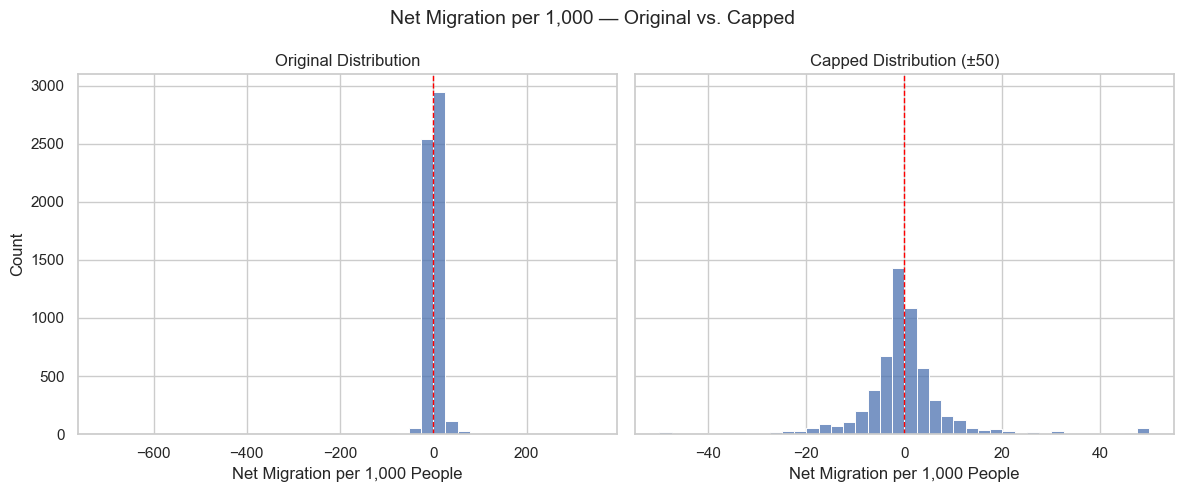

,Original
count,5712.000000
mean,0.008882
std,17.733863
min,-709.898215
1%,-29.145429
5%,-14.879145
50%,-0.294753
95%,14.405584
99%,44.691864
max,340.852702


,Capped±50
count,5712.000000
mean,0.012129
std,10.346746
min,-50.000000
1%,-29.145429
5%,-14.879145
50%,-0.294753
95%,14.405584
99%,44.691864
max,50.000000


In [4]:
# Create capped version for visualization
CAP = 50
if "net_migration_per_1000_capped" not in df_country.columns:
    df_country["net_migration_per_1000_capped"] = df_country["net_migration_per_1000"].clip(-CAP, CAP)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Original
sns.histplot(df_country["net_migration_per_1000"], bins=40, ax=axes[0])
axes[0].axvline(0, color="red", linestyle="--", lw=1)
axes[0].set_title("Original Distribution")

# Capped
sns.histplot(df_country["net_migration_per_1000_capped"], bins=40, ax=axes[1])
axes[1].axvline(0, color="red", linestyle="--", lw=1)
axes[1].set_title(f"Capped Distribution (±{CAP})")

for ax in axes:
    ax.set_xlabel("Net Migration per 1,000 People")
    ax.set_ylabel("Count")

# Force same y-scale for fair comparison
ymax = max(ax.get_ylim()[1] for ax in axes)
for ax in axes:
    ax.set_ylim(0, ymax)

plt.suptitle("Net Migration per 1,000 — Original vs. Capped", fontsize=14)
plt.tight_layout()
plt.show()

display(
    df_country["net_migration_per_1000"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_frame("Original"),
    df_country["net_migration_per_1000_capped"].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_frame(f"Capped±{CAP}")
)


### 4.2 Crisis Flag (for Modeling & EDA)

> **Why create `is_crisis`?**  
> Some countries experience *extreme spikes or drops* in migration due to wars, economic collapse, or humanitarian crises. These events can distort model training if treated as ordinary observations.  
>
> - We mark a year as crisis if **$\lvert \text{net\_migration\_per\_1000} \rvert > 50$** (`is_crisis = 1`).  
> - We **keep** these rows (no deletion) to preserve continuity.  
> - We use the **capped** version for plots and **`is_crisis`** as a modeling control.


In [5]:
# Create crisis flag
df_country["is_crisis"] = (df_country["net_migration_per_1000"].abs() > CAP).astype(int)

# Quick counts by IncomeGroup
if "IncomeGroup" in df_country.columns:
    crisis_counts = df_country.groupby("IncomeGroup")["is_crisis"].sum().sort_values(ascending=False)
    display(crisis_counts)


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_12356/4224477980.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crisis_counts = df_country.groupby("IncomeGroup")["is_crisis"].sum().sort_values(ascending=False)


IncomeGroup
High income            29
Low income             19
Lower middle income    14
Upper middle income     4
Name: is_crisis, dtype: int64

### 4.3 Outlier Countries by Income Group

> **Purpose:** Identify countries driving extreme migration patterns within each income group using a **fixed threshold** of ±50 per 1,000 (`is_crisis`). The table shows **all** crisis observations per income group and a bar chart of counts.

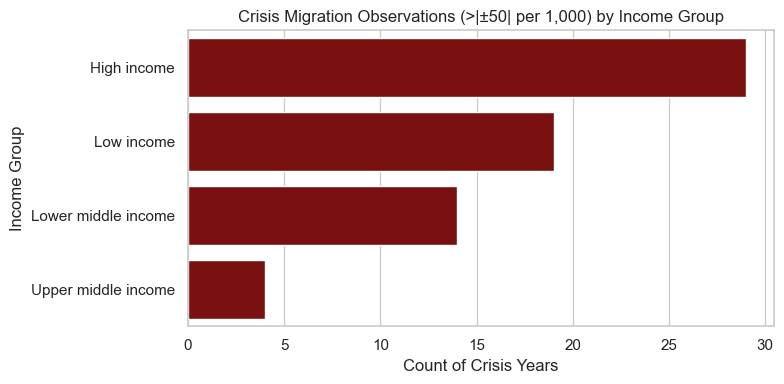

,Low income,Upper middle income,Lower middle income,High income
1,"Rwanda (1994, -305.9)","Ukraine (2022, -138.8)","Timor-Leste (1999, -315.0)","Kuwait (1990, -709.9)"
2,"Rwanda (1996, 203.9)","Bosnia and Herzegovina (1992, -103.2)","Lebanon (2013, 127.7)","Kuwait (1991, 340.9)"
3,"Eritrea (1991, -171.2)","Libya (2011, -88.7)","Bhutan (1992, -114.1)","Qatar (2006, 209.9)"
4,"Burundi (1993, -120.5)","Armenia (1992, -54.9)","Djibouti (1992, -104.2)","Qatar (2007, 203.3)"
5,"Syrian Arab Republic (2013, -96.1)",NaN,"Djibouti (1990, 86.2)","Oman (2011, 160.1)"
6,"Burundi (1994, 90.4)",NaN,"Jordan (2006, 78.2)","United Arab Emirates (2007, 128.4)"
7,"Afghanistan (1992, 90.2)",NaN,"Jordan (2013, 76.3)","Qatar (2008, 116.0)"
8,"Somalia, Fed. Rep. (1991, -83.4)",NaN,"Jordan (1990, 73.5)","Oman (2012, 91.0)"
9,"Rwanda (1995, 77.5)",NaN,"Jordan (2014, 72.3)","Qatar (2014, 90.5)"
10,"Afghanistan (1993, 76.9)",NaN,"Timor-Leste (2001, 60.5)","Qatar (2005, 83.6)"


In [6]:
# --- Crisis comparison table for all Income Groups (±50 threshold, show ALL) ---
import math

def crisis_table_by_income(df, value_col="net_migration_per_1000", cap=50):
    groups = df["IncomeGroup"].dropna().unique()
    result, counts = {}, {}

    for g in groups:
        crisis = df.loc[(df["IncomeGroup"] == g) & (df[value_col].abs() > cap)].copy()
        if crisis.empty:
            continue

        counts[g] = len(crisis)
        result[g] = (
            crisis.assign(info=lambda x: x["Country Name"]
                          + " (" + x["year"].astype(str) + ", "
                          + x[value_col].round(1).astype(str) + ")")
                  .sort_values(value_col, key=lambda x: x.abs(), ascending=False)["info"]
                  .reset_index(drop=True)
        )

    # Align length across columns
    max_len = max((len(v) for v in result.values()), default=0)
    table = pd.DataFrame({k: v.reindex(range(max_len)) for k, v in result.items()})
    table.index = range(1, len(table) + 1)

    # Plot sorted counts
    counts_series = pd.Series(counts).sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=counts_series.values, y=counts_series.index, color="darkred")
    plt.title(f"Crisis Migration Observations (>|±{cap}| per 1,000) by Income Group")
    plt.xlabel("Count of Crisis Years"); plt.ylabel("Income Group")
    plt.tight_layout(); plt.show()

    return table

crisis_table_full = crisis_table_by_income(df_country, cap=50)
display(crisis_table_full)


## 5. Global Trend Over Time

> **Purpose:** Show the global average net migration rate per year to detect common cycles or step‑changes.

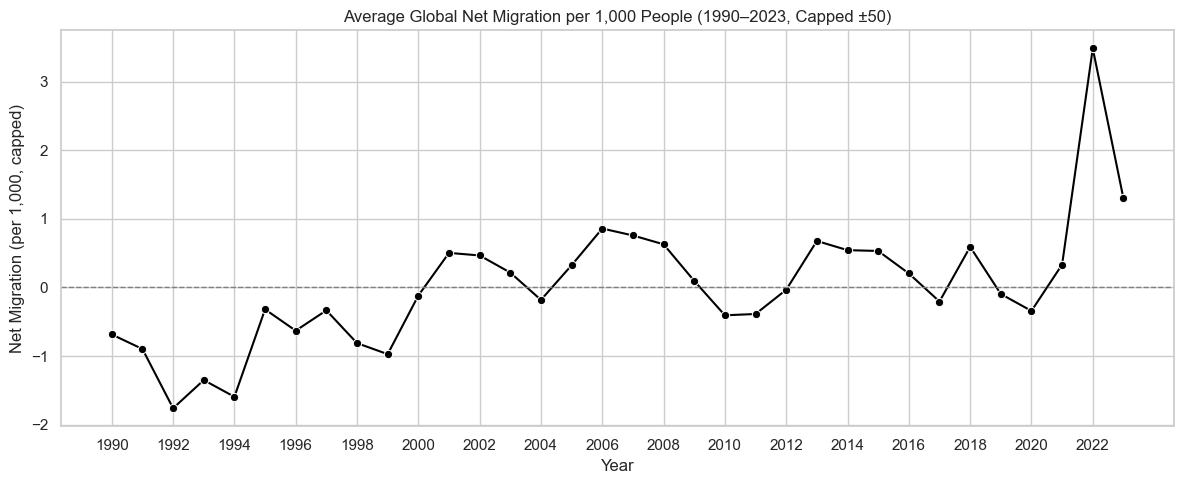

In [7]:
global_trend = (
    df_country.groupby("year")["net_migration_per_1000_capped"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(12,5))
sns.lineplot(
    data=global_trend,
    x="year", y="net_migration_per_1000_capped",
    marker="o", color="black"
)

plt.title("Average Global Net Migration per 1,000 People (1990–2023, Capped ±50)")
plt.xlabel("Year")
plt.ylabel("Net Migration (per 1,000, capped)")
plt.axhline(0, color='gray', linestyle='--', lw=1)

# Show x-axis ticks every 2 years
years = sorted(df_country["year"].unique())
plt.xticks(ticks=[y for y in years if y % 2 == 0])

plt.tight_layout()
plt.show()


## 6. Country-Level Variation

> **Purpose:** Identify countries with the **most volatile** migration histories (std. dev. across years).

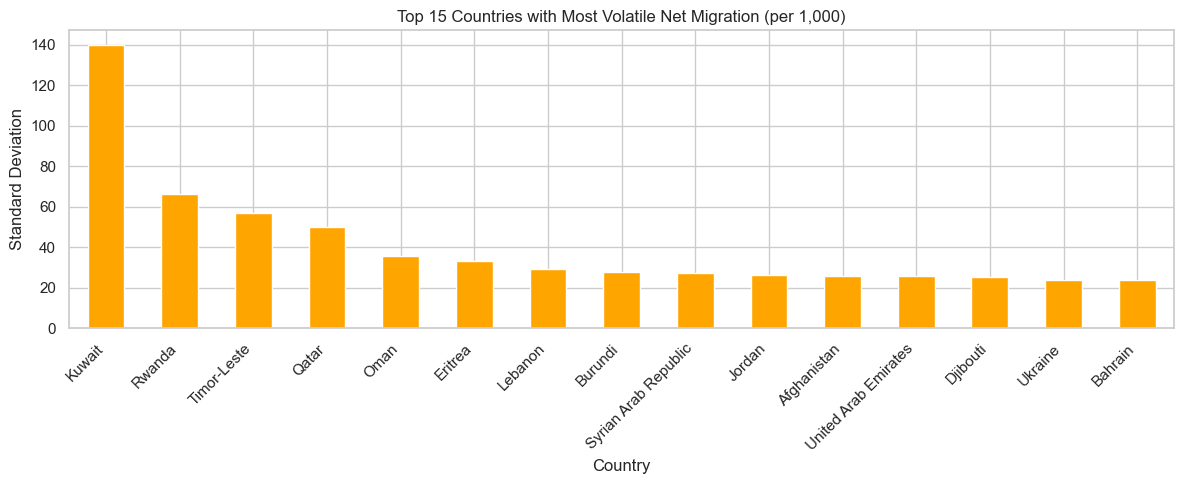

In [8]:
migration_variability = (
    df_country.groupby("Country Name")["net_migration_per_1000"].std()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12,5))
migration_variability.head(15).plot(kind='bar', color='orange')
plt.title("Top 15 Countries with Most Volatile Net Migration (per 1,000)")
plt.ylabel("Standard Deviation"); plt.xlabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


## 7. Top Migration Inflows and Outflows (Average 1990–2023)

> **Purpose:** Highlight countries with the **highest average** net inflows and outflows over the full period.

,"Average per 1,000",Type
Country Name,,
Tonga,-20.43,Outflow
Samoa,-17.41,Outflow
Moldova,-16.12,Outflow
Albania,-14.14,Outflow
Georgia,-13.71,Outflow
Guyana,-13.42,Outflow
El Salvador,-10.87,Outflow
Fiji,-10.09,Outflow
Armenia,-9.85,Outflow


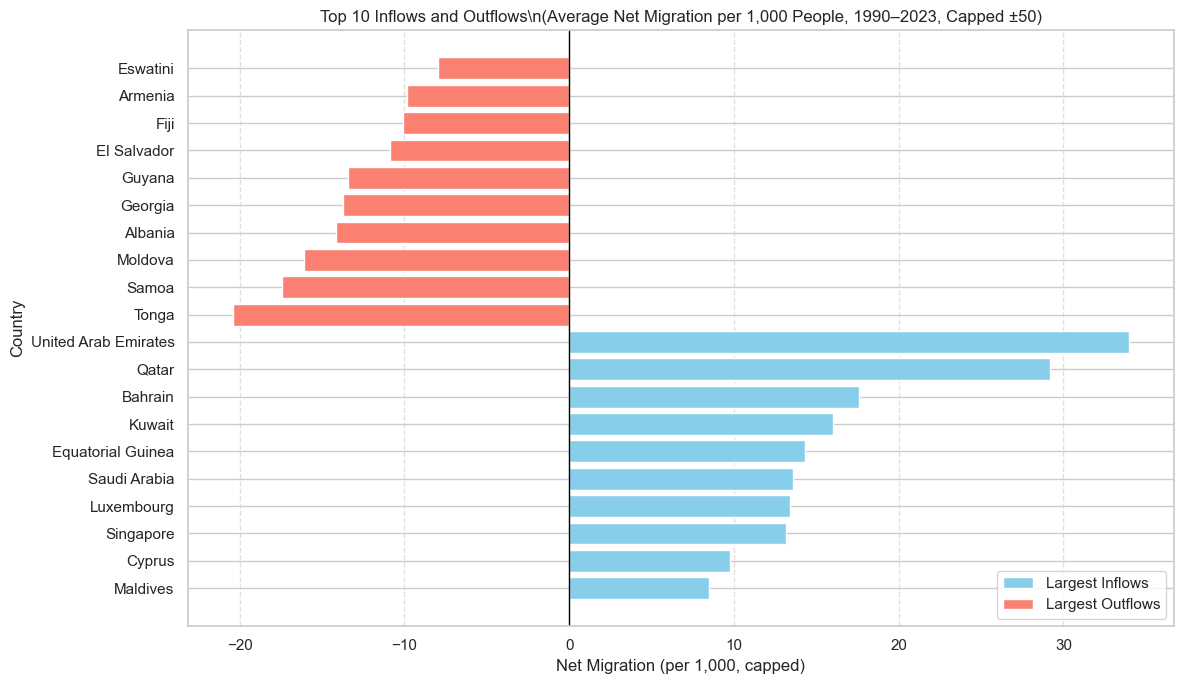

In [9]:
avg_migration = (
    df_country.groupby("Country Name")["net_migration_per_1000_capped"].mean().sort_values()
)
top_inflows = avg_migration.tail(10)
top_outflows = avg_migration.head(10)

top_summary = pd.concat([
    top_outflows.rename("Average per 1,000").to_frame().assign(Type="Outflow"),
    top_inflows.rename("Average per 1,000").to_frame().assign(Type="Inflow")
])
display(top_summary.round(2))

plt.figure(figsize=(12,7))
plt.barh(top_inflows.index, top_inflows, color="skyblue", label="Largest Inflows")
plt.barh(top_outflows.index, top_outflows, color="salmon", label="Largest Outflows")
plt.axvline(0, color="black", linewidth=1)
plt.title("Top 10 Inflows and Outflows\\n(Average Net Migration per 1,000 People, 1990–2023, Capped ±50)")
plt.xlabel("Net Migration (per 1,000, capped)"); plt.ylabel("Country")
plt.legend(loc="lower right", frameon=True)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()


## 8. Global vs Regional Migration Trends

> **Purpose:** Compare the global average against selected regions and income groups (from `df_country`).

/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_12356/2254036591.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_country.groupby(["IncomeGroup", "year"])["net_migration_per_1000_capped"]


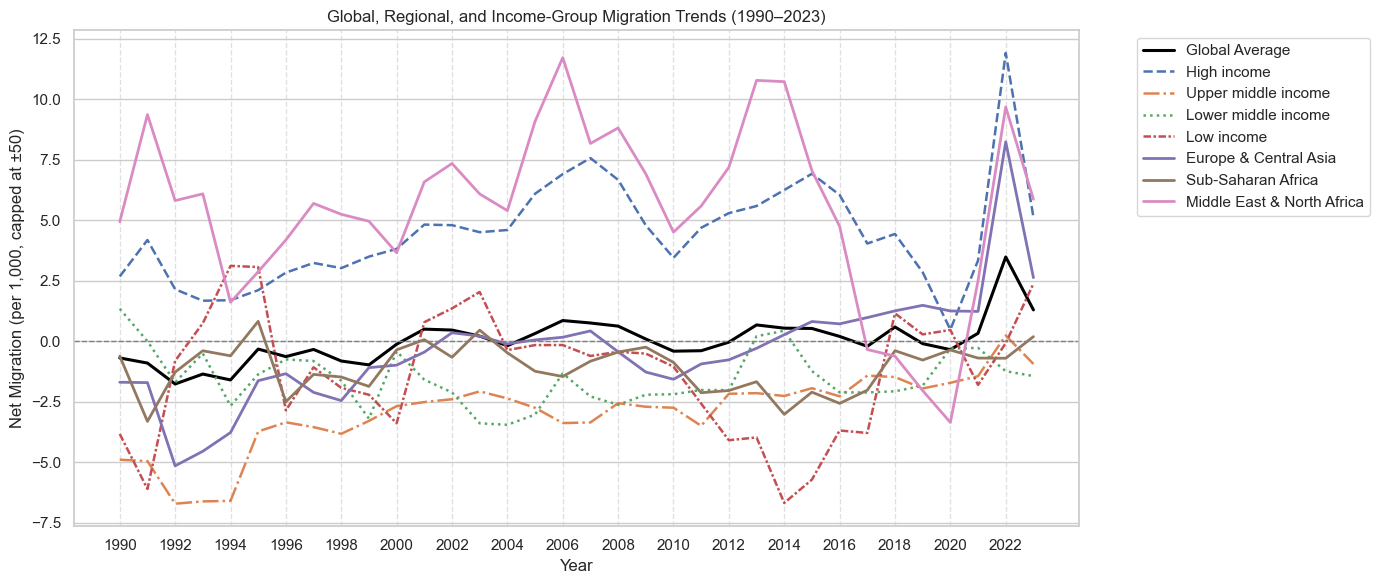

In [10]:
# --- Prepare data for Global & Regional/Income-Group Trends ---

# Ensure we have the capped migration variable
if "net_migration_per_1000_capped" not in df_country.columns:
    df_country["net_migration_per_1000_capped"] = df_country["net_migration_per_1000"].clip(-50, 50)

# Compute global average
global_trend = (
    df_country.groupby("year")["net_migration_per_1000_capped"]
    .mean()
    .reset_index()
)

# Compute regional averages
region_trends = (
    df_country.groupby(["Region", "year"])["net_migration_per_1000_capped"]
    .mean()
    .reset_index()
)

# Compute income-group averages
income_trends = (
    df_country.groupby(["IncomeGroup", "year"])["net_migration_per_1000_capped"]
    .mean()
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(14,6))

# Global (bold black)
sns.lineplot(
    data=global_trend, x="year", y="net_migration_per_1000_capped",
    color="black", linewidth=2.2, label="Global Average"
)

# Income groups (dashed styles)
for group, style in zip(
    ["High income", "Upper middle income", "Lower middle income", "Low income"],
    ["--", "-.", ":", (0, (3,1,1,1))]
):
    sub = income_trends[income_trends["IncomeGroup"] == group]
    sns.lineplot(
        data=sub, x="year", y="net_migration_per_1000_capped",
        linestyle=style, linewidth=1.8, label=group
    )

# Key regions (solid lines)
for region in ["Europe & Central Asia", "Sub-Saharan Africa", "Middle East & North Africa"]:
    sub = region_trends[region_trends["Region"] == region]
    sns.lineplot(
        data=sub, x="year", y="net_migration_per_1000_capped",
        linewidth=2.0, label=region
    )

plt.axhline(0, color="gray", linestyle="--", lw=1)
plt.title("Global, Regional, and Income-Group Migration Trends (1990–2023)")
plt.xlabel("Year")
plt.ylabel("Net Migration (per 1,000, capped at ±50)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.xticks(range(1990, 2024, 2))  # show every 2 years
plt.tight_layout()
plt.show()


## 9. Correlation and Feature Relationships

> **Purpose:** IPurpose:
To explore how migration intensity relates to key demographic, economic, and social indicators.
We use the capped version of migration (net_migration_per_1000_capped) to focus on structural relationships
rather than one-off crisis spikes that could distort correlations.

This helps reveal the underlying drivers of migration patterns — such as fertility decline,
urbanization, and income growth — without overemphasizing short-lived shocks.

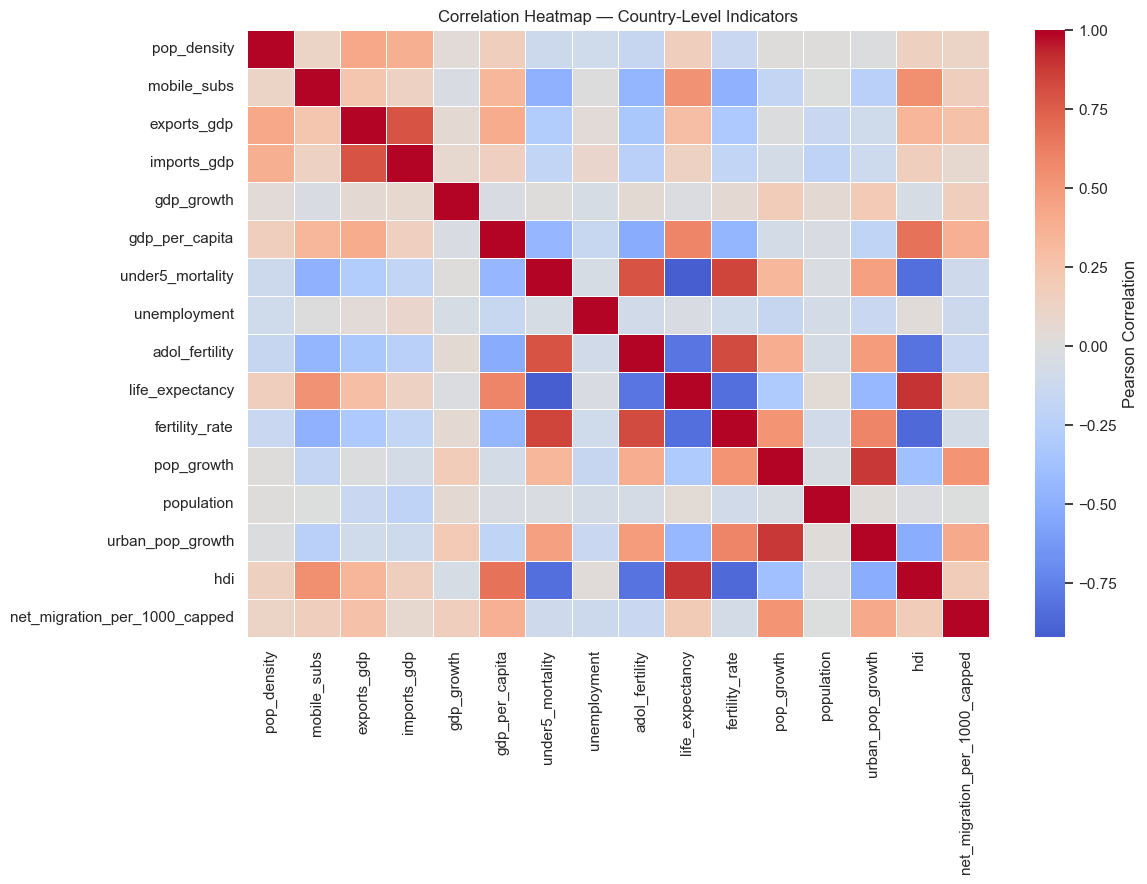

,"Correlation with Net Migration (per 1,000, capped)"
pop_growth,0.525
urban_pop_growth,0.417
gdp_per_capita,0.378
exports_gdp,0.268
life_expectancy,0.202
hdi,0.194
mobile_subs,0.171
gdp_growth,0.161
pop_density,0.117
imports_gdp,0.072


In [11]:
# Choose numeric columns present
numeric_cols = [
    'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp',
    'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment',
    'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth',
    'population', 'urban_pop_growth', 'hdi', 'net_migration_per_1000_capped'
]

corr_cols = [c for c in numeric_cols if c in df_country.columns]

# Compute correlation matrix
corr = df_country[corr_cols].corr()

# --- Plot heatmap ---
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr, cmap="coolwarm", center=0, annot=False,
    cbar_kws={"label": "Pearson Correlation"}, linewidths=0.5
)
plt.title("Correlation Heatmap — Country-Level Indicators")
plt.tight_layout()
plt.show()

# --- Show table: top correlated indicators with migration ---
corr_table = (
    corr["net_migration_per_1000_capped"]
    .drop("net_migration_per_1000_capped")
    .sort_values(ascending=False)
    .to_frame("Correlation with Net Migration (per 1,000, capped)")
    .round(3)
)

display(corr_table)


## 10. Country-Level Trends

> **Purpose:** To visualize migration trends across selected countries representing different migration contexts —

- **Conflict-driven outflows:** Ukraine, Syrian Arab Republic, Sudan, Afghanistan  
- **Transit/mixed economies:** Turkiye, Cyprus  
- **Destination economies:** United Arab Emirates, Qatar, Germany

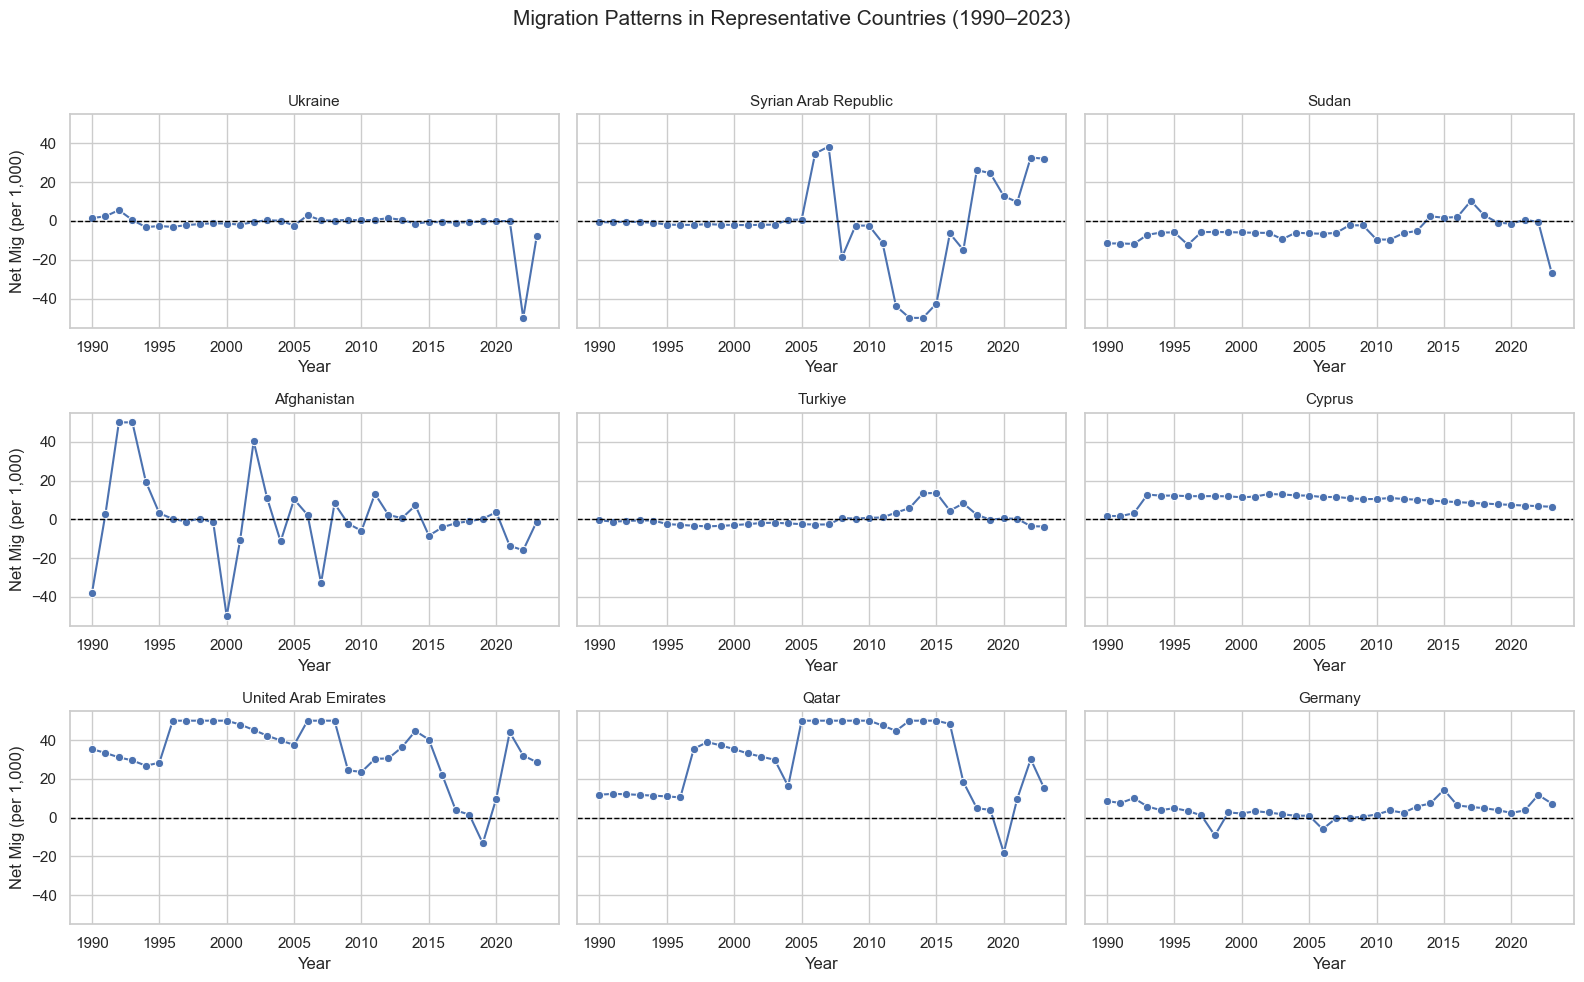

In [12]:
countries_show = [
    "Ukraine", "Syrian Arab Republic", "Sudan",
    "Afghanistan", "Turkiye", "Cyprus",
    "United Arab Emirates", "Qatar", "Germany"
]

fig, axes = plt.subplots(3, 3, figsize=(16, 10), sharey=True)
axes = axes.flatten()
for i, country in enumerate(countries_show):
    sub = df_country[df_country["Country Name"] == country]
    if not sub.empty:
        sns.lineplot(ax=axes[i], data=sub, x="year", y="net_migration_per_1000_capped", marker="o")
        axes[i].axhline(0, color="black", linestyle="--", lw=1)
        axes[i].set_title(country, fontsize=11)
        axes[i].set_xlabel("Year"); axes[i].set_ylabel("Net Mig (per 1,000)")
    else:
        axes[i].set_visible(False)

plt.suptitle("Migration Patterns in Representative Countries (1990–2023)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

## 11. Key Insights Summary

- Net migration is **highly polarized**: most observations cluster near zero, with crisis years creating extreme tails.  
- **Conflict-affected** states (e.g., Ukraine, Syria, Sudan, Afghanistan) show sustained negative migration in crisis periods.  
- **Destination economies** (UAE, Qatar — and Germany in absolute terms) show persistent inflows.  
- Economic/demographic indicators (**HDI, GDP per capita, fertility**) correlate most strongly with migration.  

➡️ The dataset is ready for **feature engineering and predictive modeling** in the next notebook.
